## Visualize Results: Maps

In [1]:
# import libraries
from cartopy import crs as ccrs, feature as cfeature
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import xarray as xr
import os
import numpy as np

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [75]:
# load country borders
countries_path = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
countries = gpd.read_file(countries_path)

# get german border
ger_border = countries[countries['NAME'] == 'Germany'].to_crs(epsg = 32632)

# load state borders
states_path = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
states = gpd.read_file(states_path)

# get german federal states
ger_states = states[states['admin'] == 'Germany'].to_crs(epsg = 32632)

### Forest Area 2024

### NDVI Trend

In [3]:
ndvi_BL = xr.open_dataset("./NDVI/NDVI_Spatial_Trend_BL.nc")

In [4]:
ndvi_BL

<xarray.Dataset> Size: 83MB
Dimensions:      (lon: 3510, lat: 2952)
Coordinates:
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
    crs          int8 1B ...
Data variables:
    NDVI         (lat, lon) float64 83MB ...

In [5]:
print(ndvi_BL)

<xarray.Dataset> Size: 83MB
Dimensions:      (lon: 3510, lat: 2952)
Coordinates:
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
    crs          int8 1B ...
Data variables:
    NDVI         (lat, lon) float64 83MB ...


In [ ]:
# NOT HARMONIZED
BL_min = ndvi_BL["NDVI"].min().item()
BL_mean = ndvi_BL["NDVI"].mean().item()
BL_max = ndvi_BL["NDVI"].max().item()

print("BL min:", BL_min)
print("BL mean:", BL_mean)
print("BL max:", BL_max)

NDVI min: -0.05812555555554636
NDVI mean: 0.008052786034029239
NDVI max: 0.26129863636368084


In [ ]:
# HARMONIZED
BL_min = ndvi_BL["NDVI"].min().item()
BL_mean = ndvi_BL["NDVI"].mean().item()
BL_max = ndvi_BL["NDVI"].max().item()

print("BL min:", BL_min)
print("BL mean:", BL_mean)
print("BL max:", BL_max)

BL min: -0.6394071879063702
BL mean: 0.0009907998703739692
BL max: 0.4284494172604225


In [7]:
ndvi_NL = xr.open_dataset("./NDVI/NDVI_Spatial_Trend_NL.nc")

In [ ]:
# NOT HARMONIZED
NL_min = ndvi_NL["NDVI"].min().item()
NL_mean = ndvi_NL["NDVI"].mean().item()
NL_max = ndvi_NL["NDVI"].max().item()

print("NL min:", NL_min)
print("NL mean:", NL_mean)
print("NL max:", NL_max)

NDVI min: -0.07535652173911758
NDVI mean: 0.00804735713633682
NDVI max: 0.2963196356275805


In [ ]:
# HARMONIZED
NL_min = ndvi_NL["NDVI"].min().item()
NL_mean = ndvi_NL["NDVI"].mean().item()
NL_max = ndvi_NL["NDVI"].max().item()

print("NL min:", NL_min)
print("NL mean:", NL_mean)
print("NL max:", NL_max)

NL min: -0.988041673294004
NL mean: 0.0007496732394771658
NL max: 0.6058073554695872


C:\Users\irish\AppData\Local\Temp\ipykernel_15532\1121153592.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


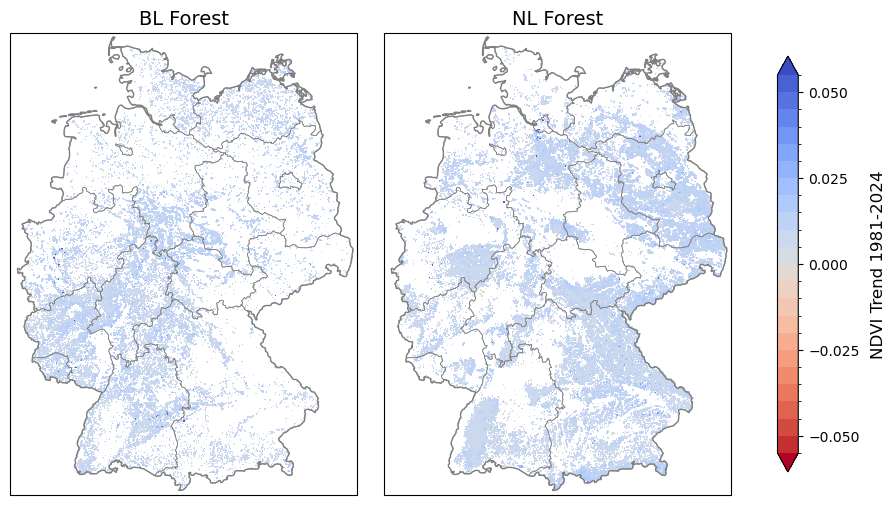

In [65]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = ndvi_BL.variables['NDVI'][:,:]
NL = ndvi_NL.variables['NDVI'][:,:]
lats = ndvi_BL.variables['lat'][:]
lons = ndvi_BL.variables['lon'][:]

# set boundaries for values
bounds = np.linspace(-0.05, 0.05, 21)  
bounds = np.concatenate(([-1], bounds, [1]))  
norm = BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['BL Forest', 'NL Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.contourf(
        lons, lats, data,
        levels=bounds,
        cmap="coolwarm_r",
        norm=norm,
        transform=projPC,
        extend="both"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)


# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("NDVI Trend 1981-2024", fontsize = 12, labelpad = 8)
cbar.set_ticks(np.linspace(-0.05, 0.05, 5))
cbar.ax.tick_params(labelsize=10) 

plt.tight_layout()
plt.show()

C:\Users\irish\AppData\Local\Temp\ipykernel_15532\538652024.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


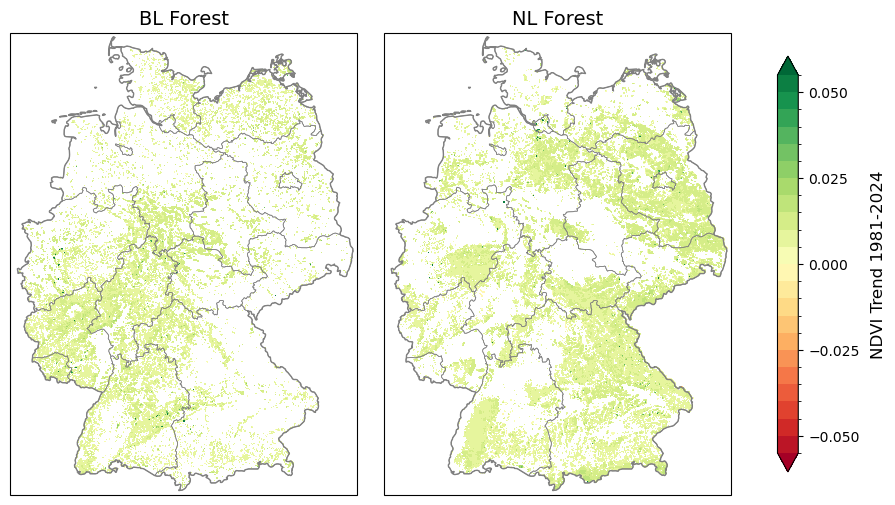

In [66]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = ndvi_BL.variables['NDVI'][:,:]
NL = ndvi_NL.variables['NDVI'][:,:]
lats = ndvi_BL.variables['lat'][:]
lons = ndvi_BL.variables['lon'][:]

# set boundaries for values
bounds = np.linspace(-0.05, 0.05, 21)  
bounds = np.concatenate(([-1], bounds, [1]))  
norm = BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['BL Forest', 'NL Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.contourf(
        lons, lats, data,
        levels=bounds,
        cmap="RdYlGn",
        norm=norm,
        transform=projPC,
        extend="both"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)


# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("NDVI Trend 1981-2024", fontsize = 12, labelpad = 8)
cbar.set_ticks(np.linspace(-0.05, 0.05, 5))
cbar.ax.tick_params(labelsize=10) 

plt.tight_layout()
plt.show()

### LAI Trend

In [84]:
lai_BL = xr.open_dataset("./LAI/LAI_Spatial_Trend_BL.nc")

In [85]:
BL_min = lai_BL["LAI"].min().item()
BL_mean = lai_BL["LAI"].mean().item()
BL_max = lai_BL["LAI"].max().item()

print("BL min:", BL_min)
print("BL mean:", BL_mean)
print("BL max:", BL_max)

BL min: -1.8536139283723991
BL mean: 0.011568539936891442
BL max: 49.66246391791805


In [86]:
lai_NL = xr.open_dataset("./LAI/LAI_Spatial_Trend_NL.nc")

In [87]:
NL_min = lai_NL["LAI"].min().item()
NL_mean = lai_NL["LAI"].mean().item()
NL_max = lai_NL["LAI"].max().item()

print("NL min:", NL_min)
print("NL mean:", NL_mean)
print("NL max:", NL_max)

NL min: -10.706519803700024
NL mean: 0.010823707069556283
NL max: 159.66961895038077


### FAPAR Trend BL

### FAPAR Trend NL

### Air Temperature Trend BL

### Air Temperature Trend NL

### Precipitation Trend Germany

### Wind Speed Trend BL

### Wind Speed Trend NL

### Soil Moisture Layer 1 Trend BL

### Soil Moisture Layer 2 Trend BL

### Soil Moisture Layer 3 Trend BL

### Soil Moisture Layer 4 Trend BL

### Soil Moisture Layer 1 Trend NL

### Soil Moisture Layer 2 Trend NL

### Soil Moisture Layer 3 Trend NL

### Soil Moisture Layer 4 Trend NL

### SPEI Trend Germany

### NIRv GPP Trend BL

### NIRv GPP Trend NL

### NPP Trend BL

### NPP Trend NL